In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE



In [12]:
# Load the dataset
dataset = 'bank-additional-full.csv'
data = pd.read_csv(dataset, delimiter=';')

# Display the first few rows
print("Dataset Preview:\n", data.head())



Dataset Preview:
    age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euri

In [14]:
# Encode the target variable
data['y'] = LabelEncoder().fit_transform(data['y'])  # 'yes' -> 1, 'no' -> 0

# Convert categorical features to dummy variables
data = pd.get_dummies(data, drop_first=True)

# Separate features and target variable
X = data.drop(columns=['y'])
y = data['y']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display class distribution
print("\nOriginal Class Distribution:\n", y_train.value_counts())

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display new class distribution after SMOTE
print("\nResampled Class Distribution:\n", pd.Series(y_train_resampled).value_counts())

# Scale numerical features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Fine-tuning Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_resampled, y_train_resampled)
best_rf = grid_rf.best_estimator_

# Evaluate Random Forest
rf_pred_labels = best_rf.predict(X_test)
rf_pred_prob = best_rf.predict_proba(X_test)[:, 1]




Original Class Distribution:
 y
0    29238
1     3712
Name: count, dtype: int64

Resampled Class Distribution:
 y
0    29238
1    29238
Name: count, dtype: int64


In [15]:
# Neural Network Model
nn_model = Sequential([
    Input(shape=(X_train_resampled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the Neural Network
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Neural Network
nn_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate Neural Network
nn_pred_prob = nn_model.predict(X_test).flatten()
nn_pred_labels = (nn_pred_prob > 0.5).astype(int)



Epoch 1/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8691 - loss: 0.2931 - val_accuracy: 0.9808 - val_loss: 0.0623
Epoch 2/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9238 - loss: 0.1637 - val_accuracy: 0.9752 - val_loss: 0.0586
Epoch 3/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9264 - loss: 0.1553 - val_accuracy: 0.9830 - val_loss: 0.0431
Epoch 4/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9308 - loss: 0.1491 - val_accuracy: 0.9836 - val_loss: 0.0389
Epoch 5/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9318 - loss: 0.1437 - val_accuracy: 0.9863 - val_loss: 0.0324
Epoch 6/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9315 - loss: 0.1433 - val_accuracy: 0.9895 - val_loss: 0.0276
Epoch 7/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9325 - loss: 0.1410 - val_accuracy: 0.9843 - val_loss: 0.0355
Epoch 8/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9327 - loss: 0.1398 - 

In [16]:
# Classification Reports
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_pred_labels))
print("\nNeural Network Classification Report:\n", classification_report(y_test, nn_pred_labels))




Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      7310
           1       0.62      0.62      0.62       928

    accuracy                           0.91      8238
   macro avg       0.78      0.78      0.78      8238
weighted avg       0.91      0.91      0.91      8238


Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.64      0.51      0.57       928

    accuracy                           0.91      8238
   macro avg       0.79      0.74      0.76      8238
weighted avg       0.91      0.91      0.91      8238



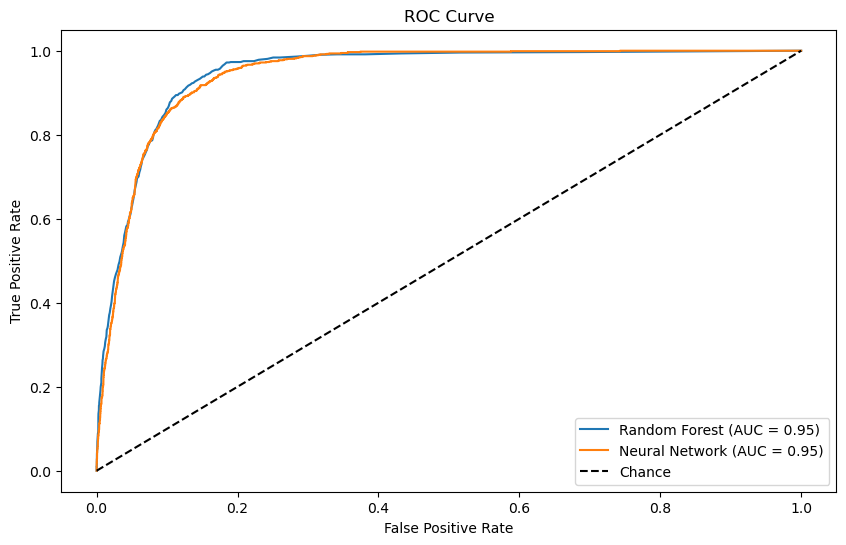

In [17]:
# Plot ROC Curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_prob)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, rf_pred_prob)))
plt.plot(nn_fpr, nn_tpr, label='Neural Network (AUC = {:.2f})'.format(roc_auc_score(y_test, nn_pred_prob)))
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [18]:
# Predictions for 20 Samples from Test Dataset
X_test_sample = X_test[:20]
y_test_sample = y_test[:20]

# Random Forest Predictions
rf_pred_labels_sample = best_rf.predict(X_test_sample)
rf_pred_prob_sample = best_rf.predict_proba(X_test_sample)[:, 1]

print("\nRandom Forest Predictions for 20 Samples:")
for i in range(len(y_test_sample)):
    print(f"Sample {i + 1}: True Label = {y_test_sample.iloc[i]}, "
          f"RF Prediction = {rf_pred_labels_sample[i]}, "
          f"RF Probability = {rf_pred_prob_sample[i]:.4f}")




Random Forest Predictions for 20 Samples:
Sample 1: True Label = 0, RF Prediction = 0, RF Probability = 0.0050
Sample 2: True Label = 0, RF Prediction = 0, RF Probability = 0.1550
Sample 3: True Label = 0, RF Prediction = 0, RF Probability = 0.3850
Sample 4: True Label = 0, RF Prediction = 0, RF Probability = 0.0050
Sample 5: True Label = 0, RF Prediction = 0, RF Probability = 0.3850
Sample 6: True Label = 0, RF Prediction = 0, RF Probability = 0.1750
Sample 7: True Label = 0, RF Prediction = 0, RF Probability = 0.0100
Sample 8: True Label = 0, RF Prediction = 0, RF Probability = 0.0000
Sample 9: True Label = 1, RF Prediction = 1, RF Probability = 0.7950
Sample 10: True Label = 0, RF Prediction = 0, RF Probability = 0.0050
Sample 11: True Label = 0, RF Prediction = 0, RF Probability = 0.3250
Sample 12: True Label = 0, RF Prediction = 0, RF Probability = 0.0000
Sample 13: True Label = 0, RF Prediction = 0, RF Probability = 0.0350
Sample 14: True Label = 0, RF Prediction = 0, RF Probabi

In [19]:
# Neural Network Predictions
nn_pred_prob_sample = nn_model.predict(X_test_sample).flatten()
nn_pred_labels_sample = (nn_pred_prob_sample > 0.5).astype(int)

print("\nNeural Network Predictions for 20 Samples:")
for i in range(len(y_test_sample)):
    print(f"Sample {i + 1}: True Label = {y_test_sample.iloc[i]}, "
          f"NN Prediction = {nn_pred_labels_sample[i]}, "
          f"NN Probability = {nn_pred_prob_sample[i]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Neural Network Predictions for 20 Samples:
Sample 1: True Label = 0, NN Prediction = 0, NN Probability = 0.0000
Sample 2: True Label = 0, NN Prediction = 0, NN Probability = 0.0317
Sample 3: True Label = 0, NN Prediction = 0, NN Probability = 0.1394
Sample 4: True Label = 0, NN Prediction = 0, NN Probability = 0.0000
Sample 5: True Label = 0, NN Prediction = 0, NN Probability = 0.3972
Sample 6: True Label = 0, NN Prediction = 0, NN Probability = 0.1360
Sample 7: True Label = 0, NN Prediction = 0, NN Probability = 0.0079
Sample 8: True Label = 0, NN Prediction = 0, NN Probability = 0.0000
Sample 9: True Label = 1, NN Prediction = 1, NN Probability = 0.7152
Sample 10: True Label = 0, NN Prediction = 0, NN Probability = 0.0000
Sample 11: True Label = 0, NN Prediction = 0, NN Probability = 0.1897
Sample 12: True Label = 0, NN Prediction = 0, NN Probability = 0.0000
Sample 13: True Label = 0, NN Prediction = 0, NN Probability = 0.0087
Sample 14: True L

In [26]:
!git add .
!git commit -m "With ROC analysis"


[main 1c5bb7c] With ROC analysis
 2 files changed, 574 insertions(+), 391 deletions(-)
